This is our structure:

1. Packages + Dataset exploration (importance of bigrams, trigrams and stop words intromission)
2. Naive Bayes and SDGClassifier to understand amount of data needed + data reduction
3. Multiclass models with reduced data to 30%: LinearSVC and SGDClassifier
4. Analyzing binary SGDClassifier models with their hyperparameters: unigrams, bigrams and trigrams
5. Testing a new dataset on known categories for inference beyond our dataset (SGDClassifier multiclass used)
6. Lemmatization (or dictionary.like words) play a negative role overall in prediction metrics.

## Dataset and packages import + Initial dataset exploration

**IMPORTANT: We have used the terminal to download additional libraries that were not initially present in the instructions given by using the command ```python -m pip install (library)```. That is why many librares like WordCloud or mpld3 may not work in default settings of the ```pminsky-lab-dev``` kernel.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mpld3
import spacy


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import precision_score, recall_score
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle

# We first import all subsequent Keras modules we will need

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from keras.callbacks import History
from keras.utils import to_categorical
import tensorflow.keras.backend as K
from tensorflow import sparse
import csv
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding, Bidirectional
from tqdm import tqdm


# And a warning hider to make our code cleaner.
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


from IPython.display import HTML, JSON
import sklearn.metrics
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from io import BytesIO

2023-06-23 21:38:17.952688: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
train=pd.read_csv("agnews_train.csv")
test=pd.read_csv("agnews_test.csv")

In [3]:
train.head()

,text,label,label_int,science_int,sports_int,world_int,business_int
0,"John Souza, a volunteer with the Boone County ...",Business,3,0,0,0,1
1,Spain needs only to beat an under-strength Fre...,Sports,1,0,1,0,0
2,"PANAMA CITY, Panama -- When the United States ...",World,2,0,0,1,0
3,"Gilbert Arenas, Jarvis Hayes and Anthony Peele...",Sports,1,0,1,0,0
4,"MEMPHIS, Tenn. -- Kobe Bryant had his worst sh...",Sports,1,0,1,0,0


In [4]:
test.head()

,text,label,label_int,science_int,sports_int,world_int,business_int
0,It #39;s over. Our relationship just hasn #39;...,Science,0,1,0,0,0
1,Toshiba Corp. announced Tuesday a 80 gigabyte ...,Science,0,1,0,0,0
2,Scientists go back to the drawing board in the...,Science,0,1,0,0,0
3,The first shuttle flight since the Columbia tr...,Science,0,1,0,0,0
4,"NEW YORK, Sept 21: Iraqi Prime Minister Iyad A...",World,2,0,0,1,0


In [5]:
print(f'The test dataset has a shape of {test.shape}, and the train set {train.shape}.' )

print(f'We observe both train ({train.isnull().any().sum()}) and test ({train.isnull().any().sum()}) do not have missing values.')

The test dataset has a shape of (10000, 7), and the train set (109999, 7).
We observe both train (0) and test (0) do not have missing values.


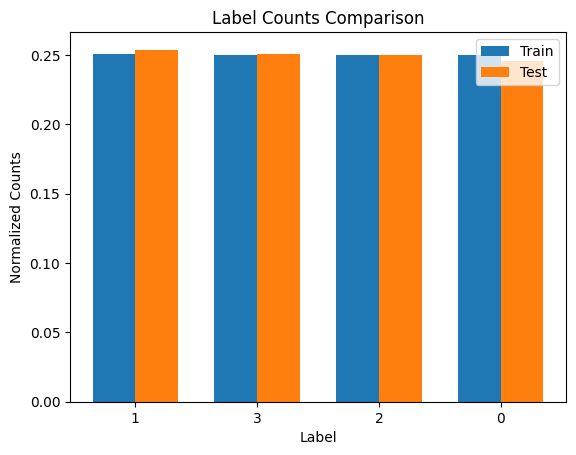

In [6]:
# We can see that they are indeed balanced by simply plotting "label_int" distribution using value_counts
# normalized.

train_label_counts = train["label_int"].value_counts(normalize=True)
test_label_counts = test["label_int"].value_counts(normalize=True)

bar_width = 0.35
x_train = np.arange(len(train_label_counts))
x_test = [x + bar_width for x in x_train]

fig, ax = plt.subplots()
ax.bar(x_train, train_label_counts, width=bar_width, label='Train')
ax.bar(x_test, test_label_counts, width=bar_width, label='Test')
ax.set_xlabel('Label')
ax.set_ylabel('Normalized Counts')
ax.set_title('Label Counts Comparison')
ax.set_xticks(x_train + bar_width / 2)
ax.set_xticklabels(train_label_counts.index)
ax.legend()
plt.show()

Great, no imbalance and no missing values. Let's now go to the word level... What is the frequency of words? Making use of the in-class example, we will apply a tokenizer which is part of the ```feature.extraction.text``` module from ```sklearn``` library, which for a first exploration may be good (as it gets rid of commas and many common language terms that may not yield significant feedback when exploring).

In [7]:
# For doing so, we first apply a function to call it

def initial_sklearn_analyzer():
    #We leave stop_words with the ones by default
    vect=CountVectorizer(stop_words=[])
    analyzer=vect.build_analyzer()
    return analyzer

#We instantiate our model
sk_analyzer = initial_sklearn_analyzer()

In [8]:
#Turn to see the words distribution. Let's count them in both train and test sets.

word_counts=Counter()
for element in [train, test]:
    for text in element.text:
        word_counts.update(sk_analyzer(text))
        
print(f'In total, we have {len(word_counts.most_common())} words in both datasets.')

In total, we have 60741 words in both datasets.


In [9]:
#And what about the amount and most common ones for each? Let's first do train set.
word_counts=Counter()
for text in train.text:
    word_counts.update(sk_analyzer(text))
    
print(f' Train set has {len(word_counts.most_common())} words.')

#And for top 20 words in frequency terms...
word_counts.most_common(20)

 Train set has 58831 words.


[('the', 182263),
 ('to', 88925),
 ('of', 82101),
 ('in', 72156),
 ('and', 60998),
 ('on', 44011),
 ('for', 35113),
 ('39', 29262),
 ('that', 25467),
 ('with', 20823),
 ('as', 20126),
 ('its', 19440),
 ('at', 19076),
 ('said', 18413),
 ('is', 18395),
 ('it', 17558),
 ('by', 17201),
 ('has', 16768),
 ('new', 16005),
 ('an', 15241)]

In [10]:
#As we instantiated the class, we have to reinstantiate in order to only take into account the test set.
word_counts=Counter()
for text in test.text:
    word_counts.update(sk_analyzer(text))

print(f' Test set has {len(word_counts.most_common())} words.')

#And for top 20 words in frequency terms...
word_counts.most_common(20)

 Test set has 22748 words.


[('the', 16771),
 ('to', 7901),
 ('of', 7472),
 ('in', 6598),
 ('and', 5622),
 ('on', 4059),
 ('for', 3110),
 ('39', 2612),
 ('that', 2321),
 ('with', 1899),
 ('its', 1826),
 ('as', 1800),
 ('at', 1758),
 ('said', 1685),
 ('it', 1613),
 ('is', 1599),
 ('by', 1569),
 ('has', 1533),
 ('new', 1389),
 ('from', 1344)]

In order to fully understand such dimensionality, let's do a wordcloud for each set. We will see how this non-semantic words play a pivotal role relative to others in both sets when it comes to frequency.

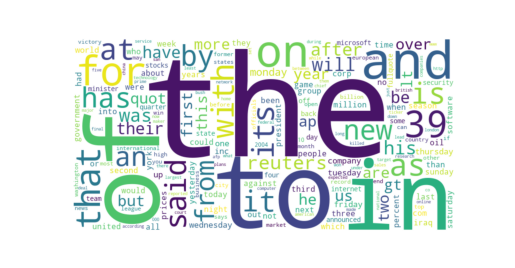

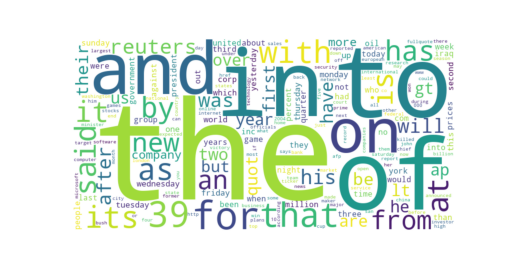

In [11]:
datasets = [train, test]

for dataset in datasets:
    word_counts = Counter()
    for text in dataset.text:
        word_counts.update(sk_analyzer(text))

    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis')
    wordcloud.generate_from_frequencies(word_counts)
    image_width, image_height = wordcloud.width, wordcloud.height

    # We create a figure with dimensions matching the word cloud image and reducing the pixels
    fig, ax = plt.subplots(figsize=(image_width/100, image_height/100), dpi=400)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_axis_off()

    # We create a tooltip function to display the frequency and rank
    def tooltip_text(word, font_size, position, orientation, random_state=None, **kwargs):
        frequency = word_counts[word]
        rank = sorted(word_counts, key=word_counts.get, reverse=True).index(word) + 1
        return f'Word: {word}\nFrequency: {frequency}\nRank: {rank}'
    mpld3.plugins.connect(fig, mpld3.plugins.PointHTMLTooltip(wordcloud, tooltip_text))

    # We save the plot to a BytesIO object for display
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    plt.close(fig)
    buffer.seek(0)
    img = buffer.getvalue()
    plt.imshow(plt.imread(BytesIO(img)))
    plt.axis('off')
    plt.show()

<div class="alert alert-block alert-danger">
<b>First conclusion:</b> Top frequency words are conjunctions, prepositions... for both train and test set. We have to go to deeper meanings or even n-grams if we want to find an approach that yields semantic identification with the features.
</div>

# Bag-of-words Naive Bayes and SGD classifiers: understanding of data amount needed to train

We will try out a bag-of-words from the linear perspective (```SGDClassifier```) and a Naive Bayes approach (```MultinomialNB```). Both of them will encode inside a ```pipeline``` three different components that will be of utility:

> **```CountVectorizer()```**: Creates a vector (or bag-of-words) from the text.

> **```TfidfTransformer()```**: Assigns frequencies to the words, weighting at the same time those that appear too much by applying the logarithmic scale on it (a brief explanation of the formula below is displayed).

> **```clf```** : Will apply the respective algorithm (```SGDClassifier``` or ```MultinomialNB```) and extract the words weights assigned during training.


TFIDF (Term Frequency Inverse Document Frequency)
- TFIDF = TF * IDF
- TF = #occurrences of term
- How frequent is the term occurring in the document?
- IDF = log (#documents / #documents with term)
- How rare is the term to be in a document?

In [12]:
# Let's begin by creating a function encoding inside the pipeline each of the two functions.

#Naive bayes
def make_sklearn_naive_bayes():
    classifier = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', MultinomialNB()),
    ])
    return classifier

#The linear model, sgd
def make_sklearn_sgd():
    classifier = Pipeline([
        ('vect', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('clf', SGDClassifier(loss='hinge', penalty='l2',
                              alpha=1e-3, random_state=42,
                              max_iter=5, tol=None)),
        ])
    return classifier

### First approach with multiclass: ```MultinomialNB( )``` and ```SDGClassifier()``` checking how using a 100% of dataset works.

In [13]:
#We will also define two functions: one for displaying a classification report and 
#confusion matrix for a multiclass problem, and another for binary.

def results_multiclass(model_fit):
    predictions = model_fit.predict(test.text)

    # We print classification report
    report = classification_report(test.label_int, predictions,
                                   target_names=["science", "sports", "world", "business"])
    print(report)

    # We also create a colourful confusion matrix
    cm = confusion_matrix(test.label_int, predictions)
    cmap = "viridis"
    sns.heatmap(cm, annot=True, cmap=cmap, fmt="d", xticklabels=["science", "sports", "world", "business"],
                yticklabels=["science", "sports", "world", "business"])
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
def results_binary(model_fit, variable):
    predictions = model_fit.predict(test.text)

    # We print classification report
    report = classification_report(test[variable], predictions)
    print(report)

    # We also create a colourful confusion matrix
    cm = confusion_matrix(test[variable], predictions)
    cmap = "viridis"
    sns.heatmap(cm, annot=True, cmap=cmap, fmt="d")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

**1. ```MultinomialNB( )```(100% dataset)**

In [14]:
# Reviewing the news by calling our function on the label_int column (which encodes all news types)

#We fit our model
naive_bayes=make_sklearn_naive_bayes().fit(train.text, train.label_int)
naive_bayes

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

              precision    recall  f1-score   support

     science       0.88      0.86      0.87      2537
      sports       0.95      0.98      0.96      2458
       world       0.90      0.89      0.89      2509
    business       0.86      0.86      0.86      2496

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



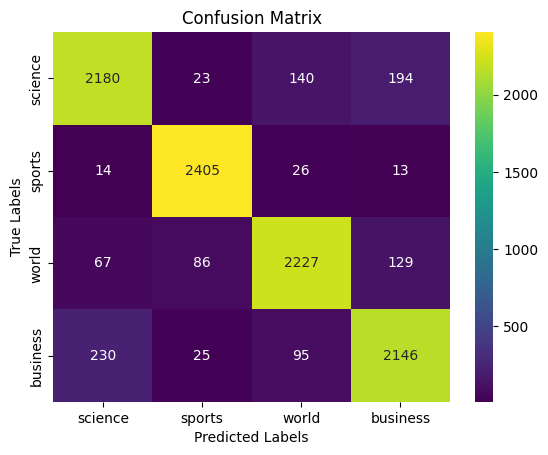

In [15]:
#We predict, and display the accuracy metrics with the classification report and confusion matrix

results_multiclass(model_fit=naive_bayes)

**2. ```SDGClassifier```(100% dataset)**

In [16]:
sgd_model=make_sklearn_sgd().fit(train.text, train.label_int)
sgd_model

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

              precision    recall  f1-score   support

     science       0.88      0.86      0.87      2537
      sports       0.95      0.98      0.96      2458
       world       0.90      0.89      0.89      2509
    business       0.86      0.86      0.86      2496

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



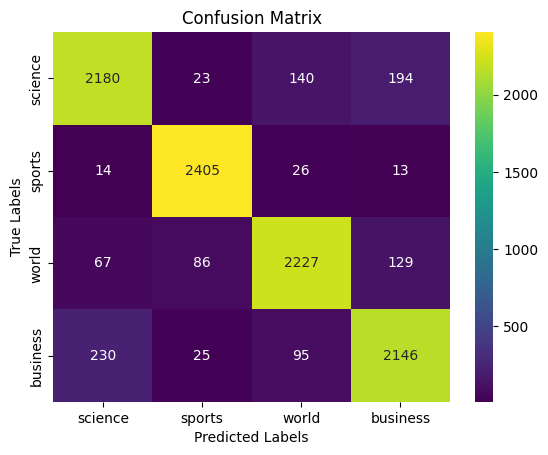

In [17]:
results_multiclass(model_fit=naive_bayes)

## Data Hungriness + Models with reduced training data

We will now analyze the data hungrinness of the model. For doing so, we will use our best model suited for explainability and performance at the small time: ```SDGClassifier()```. Using the non-hyperparameterized model for optimization of computing time, we will loop over different training sizes and display the graph with the accuracies stored.

Then, we will compute for ```LinearSVC``` and ```SDGClassifier ( )``` this new approach.

10999
21999
32999
43999
54999
65999
76999
87999
98999
109999


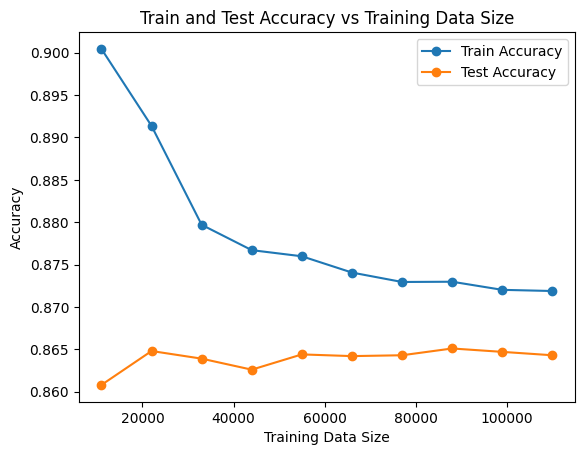

In [18]:
data_sizes = np.linspace(0.1, 1.0, 10)  # Percentages going from 10% to 10%
data_sizes_list = []  # Empty list to store the results
train_accuracies = []  # Empty list to store train accuracies
test_accuracies = []  # Empty list to store test accuracies

for data_size in data_sizes:
    # We calculate the number of samples based on the data size percentage
    num_samples = int(data_size * len(train))
    
    # We then take a random subset of the training data
    subset_train = train.sample(n=num_samples)
    
    # We create a new instance of the classifier for each iteration
    sdg_model = make_sklearn_sgd()
    
    # We fit the model on the subset of the training data
    sdg_model.fit(subset_train.text, subset_train.label_int)
    
    # We calculate the accuracy on the train set
    train_accuracy = sdg_model.score(subset_train.text, subset_train.label_int)
    train_accuracies.append(train_accuracy)
    
    # We calculate the accuracy on the test set
    test_accuracy = sdg_model.score(test.text, test.label_int)
    test_accuracies.append(test_accuracy)
    
    # We append the data size to the respective list
    data_sizes_list.append(num_samples)
    print(num_samples)
    
plt.plot(data_sizes_list, train_accuracies, marker='o', label='Train Accuracy')
plt.plot(data_sizes_list, test_accuracies, marker='o', label='Test Accuracy')
plt.xlabel('Training Data Size')
plt.ylabel('Accuracy')
plt.title('Train and Test Accuracy vs Training Data Size')
plt.legend()
plt.show()


Surprisingly, we see that the initial model is not  data hungry, even when compared to the whole test set. Therefore, we will redefine for computing purposes our test set to the 30% of the original dataset to optimize the running time of models.

In [19]:
#We redefine our tarin set as said: 30%.

train=train.sample(n=int(0.3*len(train)))
train

,text,label,label_int,science_int,sports_int,world_int,business_int
21770,"While keeping the interest rates unchanged, RB...",Business,3,0,0,0,1
107968,A London-to-Washington flight is diverted afte...,World,2,0,0,1,0
98207,GAZA (Reuters) - Palestinian militants blew u...,World,2,0,0,1,0
98781,Coca-Cola Hellenic Bottling Company has announ...,Business,3,0,0,0,1
6684,NEW YORK (Reuters) - Poultry producer Sanders...,Business,3,0,0,0,1
...,...,...,...,...,...,...,...
2383,The judge in Microsoft's appeal of the antitru...,Science,0,1,0,0,0
55933,"BioPort Corp. of Lansing, Mich., dedicated a 1...",Science,0,1,0,0,0
6417,The Abbey National turnaround plan which the b...,Business,3,0,0,0,1
97323,India and Pakistan on Tuesday held talks on nu...,World,2,0,0,1,0


So, with data hungriness analyzed and softened, we go back to our models. Our most explainable model in feature importance terms and understanding (as it is very linear) it is not able to predict as well as the ```MultinomialNB()``` we just coded. This trend really does make sense in the machine learning world (this is explained in this arXiv article: <a href="https://arxiv.org/pdf/2010.13764.pdf">Enforcing Interpretability and its Statistical Impacts:
Trade-offs between Accuracy and Interpretability</a>.

There are multiple ways we can steer such metrics by changing our models, we will try two of them subsequently:

1. **N-grams**: adding pairs of words into our word vector space, so that it can also take them into account. We will try 1 as it is, 2 and 3 pairs (all of them are cumulative, so, 3 contains 2-grams and 1-grams).
2. **Hyperparameterization using ```GridSearchCV```**: to see if a different combination we can give more robustness to the model, so that future interpretations make even more sense.

Fortunately, the hyperparameterization can take into account N-grams as a hyperparameter on its own! Therefore, the next step is clear: Improving the accuracy of our model by analyzing the hyperparameters space so that words weight interpretations are more robust. For that, we will also use ```cross-validation``` of 5 folds inside the hyperparameterization process carried out inside ```GridSearchCV```. We will use the parameter ```n_jobs```equal to -2 in order to use more CPU power to speed up the computation process.

**We will use ```LinearSVC()``` to compare, although the team decided that ```SDGClassifier()```is the most appropriate model for explainability balance and we will continue with it.

In order to do that, we will make use of the convenience function defined in class, which displays us a sorted dataframe showing the impact of the different hyperparameters. Then, we will make use of the exact set of hyperparameters to replicate the model and check for prediction metrics.

### LinearSVC & SDGClassifier Hyperparameerized (30%)

In [20]:
def crossvalidation_report_df(grid_cv): 
    """Convenience  function. 
    
    Creates a simple dataframe that reports the results of a 
    cros-validation experiment. The input grid_cv must be fit. 
    
    Returns a dataframe, sorted by rank of experiment. 
    """
    # pick columns that define each experiment (start with param)
    # and the columns that report mean_test and rank_test results
    cols = [c for c in grid_cv.cv_results_ if (c.startswith('param') or 
                                               c in ['mean_test_score', 'rank_test_score'])]

    # sort original df by rank, and select columns
    return pd.DataFrame(grid_cv.cv_results_).sort_values(by='rank_test_score')[cols]


#### Using ```MultiOutputClassifier``` within ```LinearSVC```.

In [21]:
# Create a pipeline
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer()),  # Text vectorization
    ('classifier', OneVsRestClassifier(LinearSVC()))  # Multiclass classifier
])

# Define the parameter grid for GridSearchCV
param_grid = {
    'vectorizer__ngram_range': [(1, 1), (1, 2), (1,3)],  # Unigram, bigram and trigram features
    'classifier__estimator__C': [0.1, 1.0]  # C , penaltyparameter for LinearSVC
}

# Create GridSearchCV with the pipeline and parameter grid
multiclass_grid = GridSearchCV(pipeline, param_grid, cv=5, n_jobs=-2)

Best Parameters: {'classifier__estimator__C': 1.0, 'vectorizer__ngram_range': (1, 2)}
              precision    recall  f1-score   support

     science       0.87      0.88      0.88      2537
      sports       0.94      0.98      0.96      2458
       world       0.92      0.89      0.90      2509
    business       0.87      0.86      0.87      2496

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



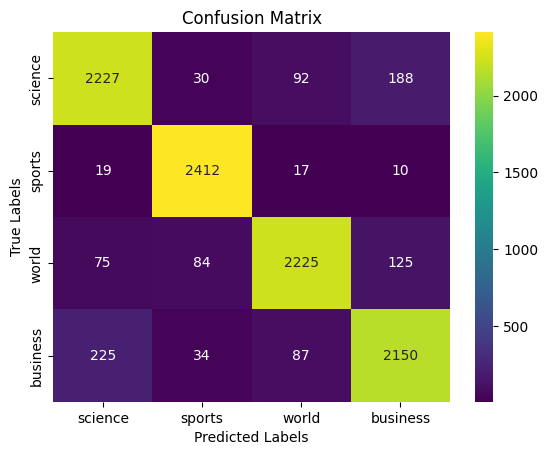

In [22]:
multiclass_grid.fit(train.text, train.label_int)
sgd_best = multiclass_grid.best_estimator_
#We extract the best model with its correspondent hyperparameters first.
sgd_best=multiclass_grid.best_estimator_
print('Best Parameters:', multiclass_grid.best_params_)

results_multiclass(model_fit=sgd_best)

In [23]:
crossvalidation_report_df(grid_cv=multiclass_grid)

,param_classifier__estimator__C,param_vectorizer__ngram_range,params,mean_test_score,rank_test_score
4,1.0,"(1, 2)","{'classifier__estimator__C': 1.0, 'vectorizer_...",0.897603,1
5,1.0,"(1, 3)","{'classifier__estimator__C': 1.0, 'vectorizer_...",0.896057,2
0,0.1,"(1, 1)","{'classifier__estimator__C': 0.1, 'vectorizer_...",0.890633,3
3,1.0,"(1, 1)","{'classifier__estimator__C': 1.0, 'vectorizer_...",0.888694,4
1,0.1,"(1, 2)","{'classifier__estimator__C': 0.1, 'vectorizer_...",0.885724,5
2,0.1,"(1, 3)","{'classifier__estimator__C': 0.1, 'vectorizer_...",0.878845,6


#### Using  ```SDGClassifier```.

In [24]:
# this defines the base sklearn pipeline we want tot tune
sgd_grid_estimator = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', SGDClassifier(loss='hinge', penalty='l2', random_state=42, max_iter=100, tol=None)),
])

# this defines the configurations
sgd_grid_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1,3)],
    'clf__alpha': (1e-3, 1e-6, 1e-9, 1e-12)
}

# we create the grid
sgd_grid= GridSearchCV(sgd_grid_estimator, sgd_grid_parameters, verbose=1, n_jobs=-1)

In [25]:
sgd_grid.fit(train.text, train.label_int)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        SGDClassifier(max_iter=100,
                                                      random_state=42,
                                                      tol=None))]),
             n_jobs=-1,
             param_grid={'clf__alpha': (0.001, 1e-06, 1e-09, 1e-12),
                         'vect__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             verbose=1)

In [26]:
crossvalidation_report_df(sgd_grid)

,param_clf__alpha,param_vect__ngram_range,params,mean_test_score,rank_test_score
5,0.000001,"(1, 3)","{'clf__alpha': 1e-06, 'vect__ngram_range': (1,...",0.896118,1
4,0.000001,"(1, 2)","{'clf__alpha': 1e-06, 'vect__ngram_range': (1,...",0.895148,2
8,0.0,"(1, 3)","{'clf__alpha': 1e-09, 'vect__ngram_range': (1,...",0.887178,3
11,0.0,"(1, 3)","{'clf__alpha': 1e-12, 'vect__ngram_range': (1,...",0.886148,4
10,0.0,"(1, 2)","{'clf__alpha': 1e-12, 'vect__ngram_range': (1,...",0.884451,5
7,0.0,"(1, 2)","{'clf__alpha': 1e-09, 'vect__ngram_range': (1,...",0.884118,6
2,0.001,"(1, 3)","{'clf__alpha': 0.001, 'vect__ngram_range': (1,...",0.866390,7
0,0.001,"(1, 1)","{'clf__alpha': 0.001, 'vect__ngram_range': (1,...",0.865602,8
1,0.001,"(1, 2)","{'clf__alpha': 0.001, 'vect__ngram_range': (1,...",0.864208,9
3,0.000001,"(1, 1)","{'clf__alpha': 1e-06, 'vect__ngram_range': (1,...",0.857602,10


Best Parameters: {'clf__alpha': 1e-06, 'vect__ngram_range': (1, 3)}
              precision    recall  f1-score   support

     science       0.87      0.87      0.87      2537
      sports       0.94      0.98      0.96      2458
       world       0.91      0.89      0.90      2509
    business       0.87      0.86      0.87      2496

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



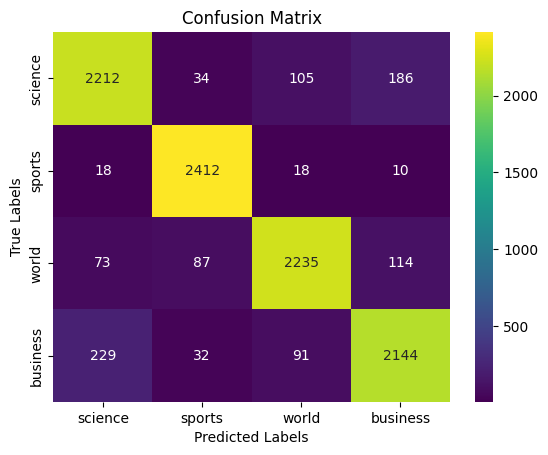

In [27]:
#And now, let's keep up the consistency and print for this model the classification report and the
#confusion matrix

#We extract the best model with its correspondent hyperparameters first.
sgd_best=sgd_grid.best_estimator_
print('Best Parameters:', sgd_grid.best_params_)

results_multiclass(model_fit=sgd_best)

So, up to here, we can draw intermediate conclusions for our ```SGDClassifier()```:

1. Sports is by far the best captured class when fitting our models, business, the worst.
2. Trigrams can help, as it adds more information to the classifier when 3 types of words are bundled together. This help is less clear though when we reduce train size. ***We must be aware of how trigrams are overfitted to train sets by nature***.
3. A certain level of regularization helps us reduce overfitting and improve the semantics reading in unseen data.

***Furthermore, a parallel computation we did before taking out 70% of dataset shows us that the performance decreased approximately by 1.5%. Given what we have won in computing power, we take that as a good tradeoff.***

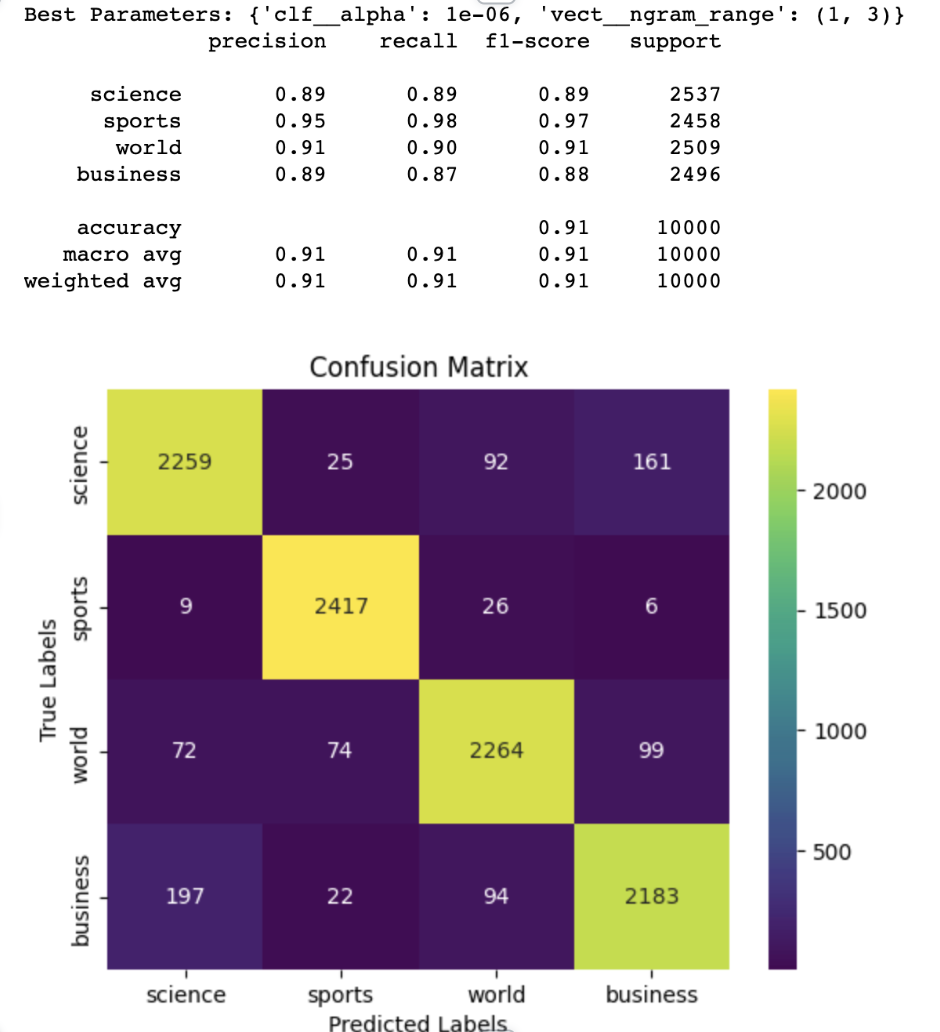

Nonetheless, this does not tell us a lot about each single category! Binarizing the problem, that is, targeting the target feature for each actegory, may help in extracting the semantics for each one!

<div class="alert alert-block alert-danger">
<b>Second conclusion:</b> Business and science are the categories that are less caught inside our notebook. Sports is by far the best one. We will try repeating the process for all four categories alone so that we see if redirecting our efforts could help.
</div>

##  ```SGDClassifier()``` for all four categories (binary class approach) ##

We will first define a function to quickly display and store the results (so we display along the way classification reports and confusion matrices; as well as a final plot displaying for all hyperparameterized model their accuracy, precision and recall).

- Classification Report (across all models)
- Confusion Matrix (across all models)
- Plot comparing across science, sports, world and business models their accuracy, precision and recall (at the end)

Then, we will define a couple of functions for the subsequent display of feature importance in terms of wording, making use of the in-class code.

- Analyzing first unigrams or singular words feature importance
- Analyzing secondly bigrams feature importance
- Analyzing then trigrams feature importance

In [28]:
##Function for the display of the classification visuals and storage of the different metrics

category_results = {}

def results_binary(model_fit, variable):
    predictions = model_fit.predict(test.text)
    
    # We print classification report
    report = classification_report(test[variable], predictions)
    print(report)
    
    # We also create a colourful confusion matrix
    cm = confusion_matrix(test[variable], predictions)
    cmap = "viridis"
    sns.heatmap(cm, annot=True, cmap=cmap, fmt="d")
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()
    
    # We extract and store classification report values
    report_dict = classification_report(test[variable], predictions, output_dict=True)
    accuracy = report_dict['accuracy']
    precision = report_dict['1']['precision']
    recall = report_dict['1']['recall']
    
    category_results[variable] = (accuracy, precision, recall)
    return accuracy, precision, recall


##Functions for analyzing individual, bigrams and trigrams feature importance

#Unigrams
def sort_feature_weights(sk_pipe, fkey='vect', wkey='clf'):
    F = sk_pipe[fkey].get_feature_names_out()
    W = sk_pipe[wkey].coef_[0]
    return sorted(zip(F, W), key=lambda fw: fw[1])

# convenience function: given a feature ngram, returns the number of "grams"
# i.e. 1 for unigrams, 2 for bigrams, ....
# simply counts the number of elements separated by space (this is how sklearn encodes unigrams)
def ngram_order(f):
    """Returns the ngram order of a feature. """
    return len(f.split())

#### Science ####

We will, here and in the subsequent labels, make use of the previous GridSearchCV structure, changing our target feature.

Fitting 5 folds for each of 12 candidates, totalling 60 fits
FOR SCIENCE, WE HAVE THE FOLLOWING:
Best Parameters: {'clf__alpha': 1e-06, 'vect__ngram_range': (1, 3)}
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      7463
           1       0.88      0.85      0.87      2537

    accuracy                           0.93     10000
   macro avg       0.92      0.91      0.91     10000
weighted avg       0.93      0.93      0.93     10000



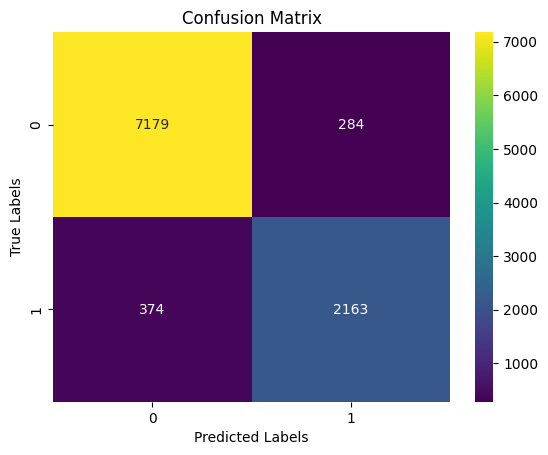

In [29]:
sgd_grid.fit(train.text, train.science_int)
sgd_best = sgd_grid.best_estimator_
print("FOR SCIENCE, WE HAVE THE FOLLOWING:")
print('Best Parameters:', sgd_grid.best_params_)
accuracy_science, precision_science, recall_science = results_binary(model_fit=sgd_best, variable="science_int")
category_results['science'] = (accuracy_science, precision_science, recall_science)

##### Unigram Feature Importance

In [30]:
#We call the function and sort them, extracting the top 20
sgd_best_weights=sort_feature_weights(sgd_best)
sgd_best_weights = sorted(sgd_best_weights, key=lambda fw: fw[1], reverse=True)
print("Weights associated with the correct classification of single-words for Sport news")
sgd_best_weights[:20]

Weights associated with the correct classification of single-words for Sport news


[('space', 6.670302745696151),
 ('internet', 5.4896175198375845),
 ('software', 5.37585482802536),
 ('nasa', 4.880929380349975),
 ('microsoft', 4.660149749890501),
 ('scientists', 4.475653758443142),
 ('apple', 4.21557160356618),
 ('web', 4.212089709495752),
 ('linux', 4.169019460492074),
 ('users', 4.076310273274009),
 ('researchers', 4.072223224323423),
 ('online', 4.0205225836346585),
 ('computer', 3.9917560037306052),
 ('spam', 3.81615886273544),
 ('reuters worldwide semiconductor', 3.764654263352366),
 ('york reuters worldwide', 3.764654263352366),
 ('singapore reuters microsoft', 3.7517841472169193),
 ('reuters worldwide', 3.622144743676812),
 ('technology', 3.579046998093081),
 ('video', 3.4758189760623295)]

In [31]:
print("Weights associated with the correct classification of single-words for non-Science news")
sgd_best_weights[-20:]

Weights associated with the correct classification of single-words for non-Science news


[('google third', -2.6191359910858845),
 ('google third quarter', -2.6191359910858845),
 ('football', -2.6214636814454773),
 ('dakar senegal', -2.684860839871064),
 ('nation 39 first', -2.7103254498552682),
 ('coach', -2.75239028938012),
 ('39 first such', -2.774478366370147),
 ('oil', -2.785664504467625),
 ('nuclear', -2.820239538025503),
 ('yesterday', -2.8810296059613987),
 ('dakar senegal reuters', -2.902653038246901),
 ('senegal reuters', -2.902653038246901),
 ('senegal reuters residents', -2.902653038246901),
 ('iraq', -2.939674790115874),
 ('francisco reuters shipments', -3.68431447490911),
 ('bangkok', -3.9631740131011783),
 ('administration initiative', -4.3264893011787375),
 ('drug administration initiative', -4.3264893011787375),
 ('bangkok reuters', -5.747096868254933),
 ('bangkok reuters japan', -6.224673255162884)]

##### Bigrams

In [32]:
print('Bigram weights associated with science reviews')
[fw for fw in sgd_best_weights if ngram_order(fw[0])==2][:20]

Bigram weights associated with science reviews


[('reuters worldwide', 3.622144743676812),
 ('ap pig', 3.3315737740390667),
 ('nation first', 2.737287081116892),
 ('36 billion', 2.509430109769877),
 ('charges lt', 2.5022780414715347),
 ('inc third', 2.3666764687988557),
 ('open source', 2.2993895787614016),
 ('pc world', 2.181827037267361),
 ('video game', 2.160916032286655),
 ('28 shares', 2.1553942087816034),
 ('angeles oct', 2.108487159477222),
 ('singapore reuters', 2.0008870947649298),
 ('leader bid', 1.890062005337851),
 ('washingtonpost com', 1.8754692580897354),
 ('inc released', 1.8724173529441805),
 ('goog initial', 1.8462184148399636),
 ('10 million', 1.8343231714730206),
 ('sun microsystems', 1.811834169694201),
 ('gt washington', 1.7911300095781522),
 ('ap hoping', 1.7544589189003457)]

In [33]:
print('Bigram weights associated with non-science reviews')
[fw for fw in sgd_best_weights if ngram_order(fw[0])==2][-20:]

Bigram weights associated with non-science reviews


[('inc initial', -1.6002270457836738),
 ('francisco reuters', -1.602280217076668),
 ('compuware 39', -1.6110023199966221),
 ('to retirees', -1.619891155543169),
 ('39 invested', -1.641736092556605),
 ('uk mobile', -1.6458063639265899),
 ('now provided', -1.660166549861311),
 ('39 largest', -1.7306206376941473),
 ('leader 39', -1.739239251744905),
 ('billion cash', -1.7550733770818825),
 ('cash acquisition', -2.0903443262324797),
 ('inc the', -2.104586135551818),
 ('gartner released', -2.1236740578088793),
 ('new york', -2.163818587321751),
 ('19 pm', -2.3727115034142012),
 ('google third', -2.6191359910858845),
 ('dakar senegal', -2.684860839871064),
 ('senegal reuters', -2.902653038246901),
 ('administration initiative', -4.3264893011787375),
 ('bangkok reuters', -5.747096868254933)]

##### Trigrams

In [34]:
print('Trigram weights associated with science reviews')
[fw for fw in sgd_best_weights if ngram_order(fw[0])==3][:20]

Trigram weights associated with science reviews


[('reuters worldwide semiconductor', 3.764654263352366),
 ('york reuters worldwide', 3.764654263352366),
 ('singapore reuters microsoft', 3.7517841472169193),
 ('ap pig manure', 3.3315737740390667),
 ('the nation first', 2.737287081116892),
 ('nation first such', 2.666834017772135),
 ('google inc third', 2.567808004327399),
 ('charges lt gt', 2.5022780414715347),
 ('restructuring charges lt', 2.5022780414715347),
 ('inc third quarter', 2.3666764687988557),
 ('28 shares of', 2.1553942087816034),
 ('angeles oct 28', 2.1553942087816034),
 ('oct 28 shares', 2.1553942087816034),
 ('los angeles oct', 2.108487159477222),
 ('and gartner inc', 2.0491613786048246),
 ('gartner inc released', 2.0491613786048246),
 ('inc released monday', 2.0491613786048246),
 ('corp and mobile', 1.990439005447688),
 ('engine leader bid', 1.890062005337851),
 ('leader bid to', 1.890062005337851)]

In [35]:
print('Trigram weights associated with non-science reviews')
[fw for fw in sgd_best_weights if ngram_order(fw[0])==3][-20:]

Trigram weights associated with non-science reviews


[('maker said sunday', -1.7502977690675539),
 ('intel is on', -1.861514783905919),
 ('and uk mobile', -2.0274586953916023),
 ('corp and uk', -2.0274586953916023),
 ('41 billion cash', -2.0903443262324797),
 ('billion cash acquisition', -2.0903443262324797),
 ('cash acquisition of', -2.0903443262324797),
 ('and gartner released', -2.1236740578088793),
 ('gartner released monday', -2.1236740578088793),
 ('engine leader 39', -2.15291366134001),
 ('leader 39 bid', -2.15291366134001),
 ('19 pm pt', -2.3727115034142012),
 ('google third quarter', -2.6191359910858845),
 ('nation 39 first', -2.7103254498552682),
 ('39 first such', -2.774478366370147),
 ('dakar senegal reuters', -2.902653038246901),
 ('senegal reuters residents', -2.902653038246901),
 ('francisco reuters shipments', -3.68431447490911),
 ('drug administration initiative', -4.3264893011787375),
 ('bangkok reuters japan', -6.224673255162884)]

#### Sports ####

Fitting 5 folds for each of 12 candidates, totalling 60 fits
FOR SPORTS, WE HAVE THE FOLLOWING:
Best Parameters: {'clf__alpha': 1e-06, 'vect__ngram_range': (1, 3)}
              precision    recall  f1-score   support

           0       0.99      0.98      0.99      7542
           1       0.95      0.97      0.96      2458

    accuracy                           0.98     10000
   macro avg       0.97      0.98      0.97     10000
weighted avg       0.98      0.98      0.98     10000



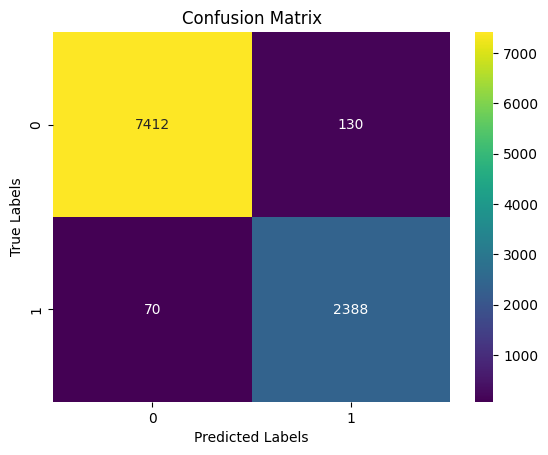

In [36]:
sgd_grid.fit(train.text, train.sports_int)
sgd_best = sgd_grid.best_estimator_
print("FOR SPORTS, WE HAVE THE FOLLOWING:")
print('Best Parameters:', sgd_grid.best_params_)
accuracy_sports, precision_sports, recall_sports = results_binary(model_fit=sgd_best, variable="sports_int")
category_results['sports'] = (accuracy_sports, precision_sports, recall_sports)

##### Sports Unigram Feature Importance

In [37]:
#We call the function and sort them, extracting the top 20
sgd_best_weights=sort_feature_weights(sgd_best)
sgd_best_weights = sorted(sgd_best_weights, key=lambda fw: fw[1], reverse=True)
print("Weights associated with the correct classification of single-words for Sports news")
sgd_best_weights[:20]

Weights associated with the correct classification of single-words for Sports news


[('coach', 6.103759618615575),
 ('team', 5.631341928926488),
 ('football', 5.352591187292446),
 ('cup', 5.19326737967998),
 ('league', 4.82109886362542),
 ('baseball', 4.729665634173814),
 ('sports', 4.694176972301937),
 ('season', 4.594645957945702),
 ('players', 4.112648970110236),
 ('olympic', 4.049452865932507),
 ('stadium', 3.72525663487691),
 ('quarterback', 3.5377900931555915),
 ('club', 3.5230746509685007),
 ('teams', 3.4783220016052945),
 ('cricket', 3.4614952137422805),
 ('39', 3.4535457687292923),
 ('olympics', 3.40904770290127),
 ('manager', 3.3426315189066247),
 ('champion', 3.335521716365566),
 ('championship', 3.2579219271014668)]

In [38]:
print("Weights associated with the correct classification of single-words for non-Sports news")
sgd_best_weights[-20:]

Weights associated with the correct classification of single-words for non-Sports news


[('video', -2.229372048498641),
 ('iraq', -2.2387340413863583),
 ('afp hosts', -2.2827880002807395),
 ('afp hosts india', -2.2827880002807395),
 ('industry', -2.2850974114565354),
 ('computer', -2.3029837438026806),
 ('technology', -2.3116264000407702),
 ('microsoft', -2.313279968379093),
 ('its', -2.3299419513006816),
 ('said', -2.3486631517519188),
 ('government', -2.3948469664111554),
 ('election', -2.4737055317094967),
 ('market', -2.5043652570178496),
 ('of', -2.5815580588915217),
 ('president', -2.8419986314527863),
 ('space', -2.965360868219203),
 ('company', -3.184630895144237),
 ('beijing serena', -3.440660366834415),
 ('beijing serena williams', -3.440660366834415),
 ('afp', -3.9498720841395087)]

##### Sports Bigrams

In [39]:
print('Bigram weights associated with sport reviews')
[fw for fw in sgd_best_weights if ngram_order(fw[0])==2][:20]

Bigram weights associated with sport reviews


[('ap serena', 3.0510518859070554),
 ('manchester united', 2.3857700802653503),
 ('india hosts', 2.2590399155565977),
 ('red sox', 2.1914677286379853),
 ('bloomfield hills', 2.102903920875709),
 ('hills michigan', 2.071523437496907),
 ('last night', 2.0405630834647406),
 ('michigan reuters', 2.02369992817499),
 ('formula one', 2.0127632990648645),
 ('kobe bryant', 2.0010061258868013),
 ('world cup', 1.9948739559913935),
 ('victory over', 1.8443360948707535),
 ('sports network', 1.7572760253153548),
 ('grand prix', 1.7139511428114105),
 ('athens reuters', 1.543001206277554),
 ('free agent', 1.44291251437675),
 ('of his', 1.4104488294657602),
 ('running back', 1.404576202267334),
 ('barry bonds', 1.3913495197803731),
 ('gold medal', 1.3899608725824035)]

In [40]:
print('Bigram weights associated with non-sport reviews')
[fw for fw in sgd_best_weights if ngram_order(fw[0])==2][-20:]

Bigram weights associated with non-sport reviews


[('wall street', -0.8777142849562166),
 ('game to', -0.8843723261970928),
 ('the nation', -0.8989063087995387),
 ('the state', -0.9255852695152802),
 ('united nations', -0.9385053235317922),
 ('in iraq', -0.945342083268648),
 ('the government', -1.0208572288546127),
 ('open source', -1.0272479117972828),
 ('yasser arafat', -1.0664399660738906),
 ('greece michael', -1.1038970672430026),
 ('the uk', -1.1062637692113189),
 ('the country', -1.110153651902263),
 ('canadian press', -1.2921817340527344),
 ('the world', -1.2922473683543527),
 ('video game', -1.3933895963813494),
 ('prime minister', -1.6909085025645971),
 ('the company', -1.7479118927622652),
 ('athens greece', -2.0876803619750794),
 ('afp hosts', -2.2827880002807395),
 ('beijing serena', -3.440660366834415)]

##### Sports Trigrams

In [41]:
print('Trigram weights associated with sport reviews')
[fw for fw in sgd_best_weights if ngram_order(fw[0])==3][:20]

Trigram weights associated with sport reviews


[('ap serena williams', 3.0510518859070554),
 ('michigan reuters rampant', 2.5018878877907484),
 ('bangalore india hosts', 2.2590399155565977),
 ('india hosts india', 2.2590399155565977),
 ('hills michigan reuters', 2.02369992817499),
 ('bloomfield hills michigan', 2.0108484797901847),
 ('round of the', 1.308701920108881),
 ('to bring baseball', 0.9962075625751654),
 ('hall of fame', 0.9618584679666385),
 ('the montreal expos', 0.9375932588040968),
 ('out of the', 0.8715824193285413),
 ('the second test', 0.8415440667876766),
 ('baseball called unacceptable', 0.8174602440493661),
 ('bring baseball back', 0.8174602440493661),
 ('financing move major', 0.8174602440493661),
 ('league baseball called', 0.8174602440493661),
 ('move major league', 0.8174602440493661),
 ('private financing move', 0.8174602440493661),
 ('stage of the', 0.8125253267741154),
 ('international olympic committee', 0.809961499816879)]

In [42]:
print('Trigram weights associated with non-sport reviews')
[fw for fw in sgd_best_weights if ngram_order(fw[0])==3][-20:]

Trigram weights associated with non-sport reviews


[('andy roddick eases', -0.7608632098594318),
 ('eases into the', -0.7608632098594318),
 ('open in straight', -0.7608632098594318),
 ('roddick eases into', -0.7608632098594318),
 ('baseball on his', -0.7613540393986816),
 ('blames quantum baseball', -0.7613540393986816),
 ('fan blames quantum', -0.7613540393986816),
 ('his team misfortunes', -0.7613540393986816),
 ('quantum baseball on', -0.7613540393986816),
 ('sox fan blames', -0.7613540393986816),
 ('and the los', -0.7773570143268109),
 ('bring major league', -0.8191247346439421),
 ('league baseball back', -0.8191247346439421),
 ('to bring major', -0.8191247346439421),
 ('inning and the', -0.8641773216075148),
 ('athens greece michael', -1.1038970672430026),
 ('greece michael phelps', -1.1038970672430026),
 ('game to win', -1.5942668305593872),
 ('afp hosts india', -2.2827880002807395),
 ('beijing serena williams', -3.440660366834415)]

#### World ####

Fitting 5 folds for each of 12 candidates, totalling 60 fits
FOR WORLD, WE HAVE THE FOLLOWING:
Best Parameters: {'clf__alpha': 1e-06, 'vect__ngram_range': (1, 3)}
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      7491
           1       0.93      0.88      0.90      2509

    accuracy                           0.95     10000
   macro avg       0.94      0.93      0.93     10000
weighted avg       0.95      0.95      0.95     10000



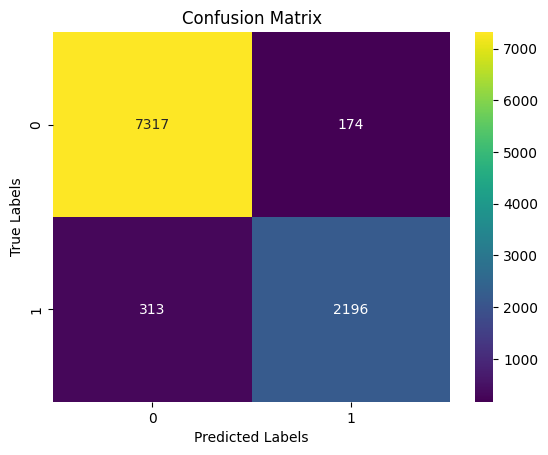

In [43]:
sgd_grid.fit(train.text, train.world_int)
sgd_best = sgd_grid.best_estimator_
print("FOR WORLD, WE HAVE THE FOLLOWING:")
print('Best Parameters:', sgd_grid.best_params_)
accuracy_world, precision_world, recall_world = results_binary(model_fit=sgd_best, variable="world_int")
category_results['world'] = (accuracy_world, precision_world, recall_world)

##### World Unigram Feature Importance

In [44]:
#We call the function and sort them, extracting the top 20
sgd_best_weights=sort_feature_weights(sgd_best)
sgd_best_weights = sorted(sgd_best_weights, key=lambda fw: fw[1], reverse=True)
print("Weights associated with the correct classification of single-words for World news")
sgd_best_weights[:20]

Weights associated with the correct classification of single-words for World news


[('afp', 7.879525371791261),
 ('bangkok reuters japan', 6.261382233077325),
 ('bangkok reuters', 5.746591270343167),
 ('iraq', 5.6220907784520735),
 ('president', 5.335616314804925),
 ('nuclear', 5.078394072395867),
 ('military', 4.686888400314532),
 ('iraqi', 4.676162606585797),
 ('bangkok', 4.449861790346371),
 ('leader', 4.144031676547763),
 ('administration initiative', 4.101079887169163),
 ('drug administration initiative', 4.101079887169163),
 ('palestinian', 4.039648951261373),
 ('elections', 4.022236894076848),
 ('canadian press', 3.819965459378481),
 ('iran', 3.756120506837847),
 ('killed', 3.6379628531106363),
 ('election', 3.556888727097219),
 ('minister', 3.541709958863032),
 ('beijing serena', 3.480668045518527)]

In [45]:
print("Weights associated with the correct classification of single-words for non-World news")
sgd_best_weights[-20:]

Weights associated with the correct classification of single-words for non-World news


[('software', -2.551886971584918),
 ('reuters the dollar', -2.5882730261279003),
 ('company', -2.6124757595641253),
 ('chicago reuters', -2.6228694166971938),
 ('players', -2.637578473104319),
 ('microsoft', -2.696668809272173),
 ('space', -2.796323281409212),
 ('singapore reuters', -2.806337621581202),
 ('39', -2.9955043629974685),
 ('shanghai reuters', -3.1004764795647763),
 ('ap serena', -3.166914615751617),
 ('ap serena williams', -3.166914615751617),
 ('internet', -3.2325602360984536),
 ('ap pig', -3.2642692533514057),
 ('ap pig manure', -3.2642692533514057),
 ('shanghai reuters china', -3.324048471917677),
 ('chicago reuters illinois', -3.693244354208011),
 ('singapore reuters microsoft', -3.7921259122407607),
 ('ap brazil', -3.802801279429585),
 ('ap brazil economy', -4.187851627537638)]

##### World Bigrams

In [46]:
print('Bigram weights associated with world reviews')
[fw for fw in sgd_best_weights if ngram_order(fw[0])==2][:20]

Bigram weights associated with world reviews


[('bangkok reuters', 5.746591270343167),
 ('administration initiative', 4.101079887169163),
 ('canadian press', 3.819965459378481),
 ('beijing serena', 3.480668045518527),
 ('york stocks', 3.0854515628632706),
 ('senegal reuters', 3.0142935397179373),
 ('dakar senegal', 2.7869509676884223),
 ('prime minister', 2.5191109691837315),
 ('united nations', 2.3397483943083093),
 ('athens greece', 2.3176908713907416),
 ('north korea', 2.0411660908031735),
 ('in iraq', 1.9939033378763784),
 ('yasser arafat', 1.9689777880732215),
 ('ap britain', 1.8554225110235636),
 ('britain telecommunications', 1.8554225110235636),
 ('afp hosts', 1.745661411979393),
 ('ap federal', 1.7241310518151347),
 ('inc initial', 1.7042962182741355),
 ('rock ark', 1.6425831153549852),
 ('ark wal', 1.6225034716384676)]

In [47]:
print('Bigram weights associated with non-world reviews')
[fw for fw in sgd_best_weights if ngram_order(fw[0])==2][-20:]

Bigram weights associated with non-world reviews


[('39 efforts', -1.2775193285254278),
 ('nation first', -1.3150103241222857),
 ('athens reuters', -1.3230597055706026),
 ('nearly million', -1.3356008915156972),
 ('india space', -1.408341619106116),
 ('bangalore india', -1.4464291335025792),
 ('london europe', -1.4502884947723886),
 ('goog initial', -1.4617067619552477),
 ('york reuters', -1.618361335964497),
 ('39 telecommunications', -1.6938379452344159),
 ('india hosts', -1.694279936667453),
 ('hills michigan', -1.9779902161201908),
 ('michigan reuters', -2.0177063708267173),
 ('bloomfield hills', -2.029639415064235),
 ('chicago reuters', -2.6228694166971938),
 ('singapore reuters', -2.806337621581202),
 ('shanghai reuters', -3.1004764795647763),
 ('ap serena', -3.166914615751617),
 ('ap pig', -3.2642692533514057),
 ('ap brazil', -3.802801279429585)]

##### World Trigrams

In [48]:
print('Trigram weights associated with world reviews')
[fw for fw in sgd_best_weights if ngram_order(fw[0])==3][:20]

Trigram weights associated with world reviews


[('bangkok reuters japan', 6.261382233077325),
 ('drug administration initiative', 4.101079887169163),
 ('beijing serena williams', 3.480668045518527),
 ('new york stocks', 3.0854515628632706),
 ('dakar senegal reuters', 3.0142935397179373),
 ('senegal reuters residents', 3.0142935397179373),
 ('36 million tuesday', 2.0850309024063343),
 ('nearly 36 million', 2.0850309024063343),
 ('ap federal regulators', 1.9311120511826092),
 ('of nearly 36', 1.8780758722616058),
 ('ap britain telecommunications', 1.8554225110235636),
 ('britain telecommunications regulator', 1.8554225110235636),
 ('afp hosts india', 1.745661411979393),
 ('calif in sign', 1.7042962182741355),
 ('google inc initial', 1.7042962182741355),
 ('inc initial public', 1.7042962182741355),
 ('little rock ark', 1.6425831153549852),
 ('ark wal mart', 1.6225034716384676),
 ('rock ark wal', 1.6225034716384676),
 ('39 first satellite', 1.5855383359018091)]

In [49]:
print('Trigram weights associated with non-world reviews')
[fw for fw in sgd_best_weights if ngram_order(fw[0])==3][-20:]

Trigram weights associated with non-world reviews


[('inc goog initial', -1.4617067619552477),
 ('nation first satellite', -1.4637513561212558),
 ('reuters india space', -1.4637513561212558),
 ('new york reuters', -1.618361335964497),
 ('39 telecommunications regulator', -1.6938379452344159),
 ('britain 39 telecommunications', -1.6938379452344159),
 ('bangalore india hosts', -1.694279936667453),
 ('india hosts india', -1.694279936667453),
 ('hills michigan reuters', -2.0177063708267173),
 ('bloomfield hills michigan', -2.0341628576626083),
 ('nearly million tuesday', -2.1039731434506703),
 ('of nearly million', -2.1039731434506703),
 ('michigan reuters rampant', -2.50188788779073),
 ('reuters the dollar', -2.5882730261279003),
 ('ap serena williams', -3.166914615751617),
 ('ap pig manure', -3.2642692533514057),
 ('shanghai reuters china', -3.324048471917677),
 ('chicago reuters illinois', -3.693244354208011),
 ('singapore reuters microsoft', -3.7921259122407607),
 ('ap brazil economy', -4.187851627537638)]

#### Business ####

Fitting 5 folds for each of 12 candidates, totalling 60 fits
FOR BUSINESS, WE HAVE THE FOLLOWING:
Best Parameters: {'clf__alpha': 1e-06, 'vect__ngram_range': (1, 3)}
              precision    recall  f1-score   support

           0       0.95      0.96      0.95      7504
           1       0.87      0.85      0.86      2496

    accuracy                           0.93     10000
   macro avg       0.91      0.90      0.91     10000
weighted avg       0.93      0.93      0.93     10000



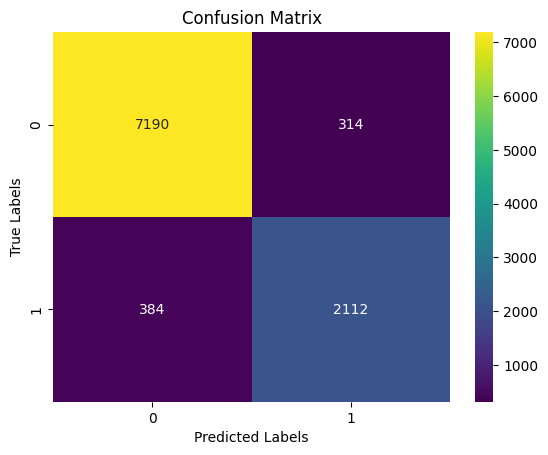

In [50]:
sgd_grid.fit(train.text, train.business_int)
sgd_best = sgd_grid.best_estimator_
print("FOR BUSINESS, WE HAVE THE FOLLOWING:")
print('Best Parameters:', sgd_grid.best_params_)
accuracy_business, precision_business, recall_business = results_binary(model_fit=sgd_best, variable="business_int")
category_results['business'] = (accuracy_business, precision_business, recall_business)

##### Business Unigram Feature Importance

In [51]:
#We call the function and sort them, extracting the top 20
sgd_best_weights=sort_feature_weights(sgd_best)
sgd_best_weights = sorted(sgd_best_weights, key=lambda fw: fw[1], reverse=True)
print("Weights associated with the correct classification of single-words for Business news")
sgd_best_weights[:20]

Weights associated with the correct classification of single-words for Business news


[('oil', 4.6790456501043005),
 ('ap brazil economy', 4.506492512241599),
 ('ap brazil', 4.245292651953668),
 ('investors', 3.8160484909236367),
 ('chicago reuters illinois', 3.8086582402770155),
 ('tax', 3.800136417815908),
 ('retailer', 3.734482637605972),
 ('francisco reuters shipments', 3.725479000989905),
 ('us', 3.667286798294617),
 ('airlines', 3.6330190810484493),
 ('bank', 3.621790841790513),
 ('prices', 3.5395692368509066),
 ('airline', 3.4972878377582557),
 ('shanghai reuters china', 3.3925855538128906),
 ('investment', 3.3825142004448794),
 ('financial', 3.2277136810681344),
 ('billion', 3.209064715991674),
 ('39 first such', 3.136366848940179),
 ('shanghai reuters', 3.0938194090331166),
 ('chicago reuters', 3.0815653021569145)]

In [52]:
print("Weights associated with the correct classification of single-words for non-Business news")
sgd_best_weights[-20:]

Weights associated with the correct classification of single-words for non-Business news


[('internet', -2.25714888396594),
 ('ap federal', -2.2787420702195833),
 ('inc third', -2.307670678319087),
 ('inc third quarter', -2.307670678319087),
 ('linux', -2.3510314252873066),
 ('nation first', -2.367863721324624),
 ('the nation first', -2.367863721324624),
 ('software', -2.6183584247712544),
 ('game', -2.6634492209729626),
 ('google inc third', -2.6685063574382806),
 ('team', -2.8885574608127693),
 ('nation first such', -2.9900866259869496),
 ('new york stocks', -3.1722917695501214),
 ('york stocks', -3.1722917695501214),
 ('reuters worldwide', -3.6221447436768117),
 ('reuters worldwide semiconductor', -3.764654263352366),
 ('york reuters worldwide', -3.764654263352366),
 ('36', -3.8826030054284724),
 ('afp', -4.107674026033726),
 ('ap', -9.560172784587111)]

##### Business Bigrams

In [53]:
print('Bigram weights associated with business reviews')
[fw for fw in sgd_best_weights if ngram_order(fw[0])==2][:20]

Bigram weights associated with business reviews


[('ap brazil', 4.245292651953668),
 ('shanghai reuters', 3.0938194090331166),
 ('chicago reuters', 3.0815653021569145),
 ('google third', 2.670491598754241),
 ('19 pm', 2.4073971186024163),
 ('39 largest', 2.3769796311835107),
 ('washington reuters', 2.352870904986148),
 ('shares of', 2.2443432999147994),
 ('cash acquisition', 2.0903443262324783),
 ('gartner released', 2.0820333900087094),
 ('the dollar', 1.9528829045259501),
 ('martha stewart', 1.9464287126791167),
 ('inc the', 1.9336531004514055),
 ('forbes com', 1.8930774684982898),
 ('dow jones', 1.8751103278908752),
 ('uk mobile', 1.8131720504721351),
 ('us airways', 1.793885250457604),
 ('now provided', 1.7550332098533852),
 ('billion cash', 1.7506439057750307),
 ('oil prices', 1.744118385583243)]

In [54]:
print('Bigram weights associated with non-business reviews')
[fw for fw in sgd_best_weights if ngram_order(fw[0])==2][-20:]

Bigram weights associated with non-business reviews


[('intel corp', -1.5506933566661705),
 ('oct 28', -1.5993409922090323),
 ('goog the', -1.6182014575469195),
 ('sent stocks', -1.6440948612935076),
 ('manchester united', -1.7301053545311444),
 ('and mobile', -1.7320243244093205),
 ('services provided', -1.7550856317610175),
 ('gartner inc', -1.8257337595570677),
 ('canadian press', -1.8344471535479807),
 ('inc released', -1.8356376723105852),
 ('charges lt', -1.913506737595883),
 ('leader bid', -2.0560667801349948),
 ('36 billion', -2.09152264777372),
 ('angeles oct', -2.1122063530553805),
 ('28 shares', -2.195308916351628),
 ('ap federal', -2.2787420702195833),
 ('inc third', -2.307670678319087),
 ('nation first', -2.367863721324624),
 ('york stocks', -3.1722917695501214),
 ('reuters worldwide', -3.6221447436768117)]

##### Business Trigrams

In [55]:
print('Trigram weights associated with business reviews')
[fw for fw in sgd_best_weights if ngram_order(fw[0])==3][:20]

Trigram weights associated with business reviews


[('ap brazil economy', 4.506492512241599),
 ('chicago reuters illinois', 3.8086582402770155),
 ('francisco reuters shipments', 3.725479000989905),
 ('shanghai reuters china', 3.3925855538128906),
 ('39 first such', 3.136366848940179),
 ('reuters the dollar', 2.9284152326165698),
 ('google third quarter', 2.670491598754241),
 ('nation 39 first', 2.499800296847493),
 ('engine leader 39', 2.448411614857271),
 ('leader 39 bid', 2.448411614857271),
 ('19 pm pt', 2.4073971186024163),
 ('and uk mobile', 2.1656945155319276),
 ('corp and uk', 2.1656945155319276),
 ('41 billion cash', 2.0903443262324783),
 ('billion cash acquisition', 2.0903443262324783),
 ('cash acquisition of', 2.0903443262324783),
 ('and gartner released', 2.0820333900087094),
 ('gartner released monday', 2.0820333900087094),
 ('intel is on', 2.041355920197256),
 ('maker said sunday', 1.900323292130495)]

In [56]:
print('Trigram weights associated with business reviews')
[fw for fw in sgd_best_weights if ngram_order(fw[0])==3][-20:]

Trigram weights associated with business reviews


[('charges lt gt', -1.913506737595883),
 ('restructuring charges lt', -1.913506737595883),
 ('and mobile phone', -1.9935144313899786),
 ('and gartner inc', -2.008178151032735),
 ('gartner inc released', -2.008178151032735),
 ('inc released monday', -2.008178151032735),
 ('engine leader bid', -2.0560667801349948),
 ('leader bid to', -2.0560667801349948),
 ('los angeles oct', -2.1122063530553805),
 ('corp and mobile', -2.1800046250141216),
 ('28 shares of', -2.195308916351628),
 ('angeles oct 28', -2.195308916351628),
 ('oct 28 shares', -2.195308916351628),
 ('inc third quarter', -2.307670678319087),
 ('the nation first', -2.367863721324624),
 ('google inc third', -2.6685063574382806),
 ('nation first such', -2.9900866259869496),
 ('new york stocks', -3.1722917695501214),
 ('reuters worldwide semiconductor', -3.764654263352366),
 ('york reuters worldwide', -3.764654263352366)]

### Putting our metrics together

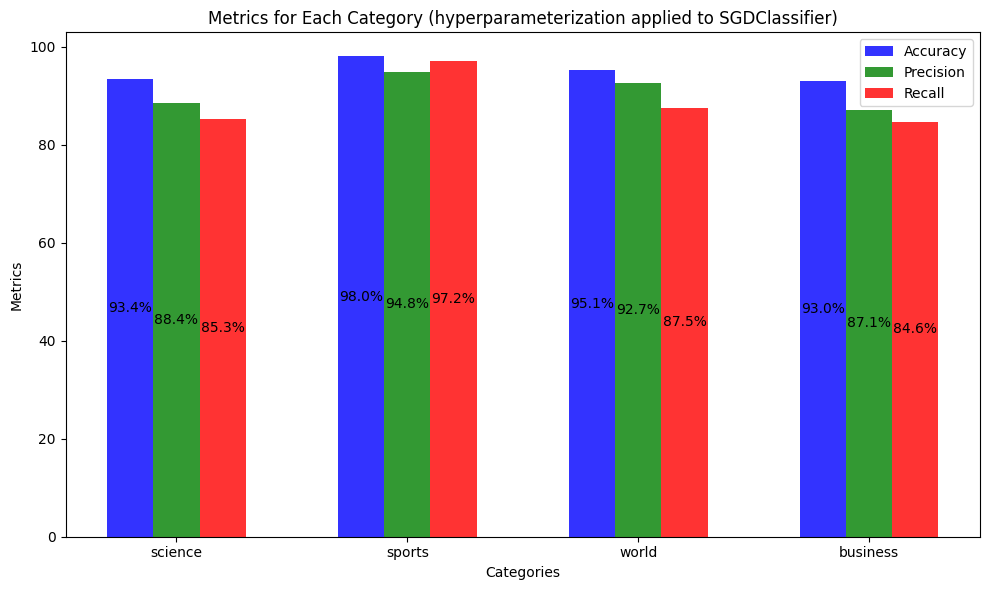

In [57]:
# Plotting the bar chart
categories = ['science', 'sports', 'world', 'business']
metrics = ['Accuracy', 'Precision', 'Recall']

fig, ax = plt.subplots(figsize=(10, 6))
bar_width = 0.2
opacity = 0.8
index = np.arange(len(categories))

# Plotting accuracy
accuracy_values = [category_results[category][0] * 100 for category in categories]
rects_accuracy = ax.bar(index, accuracy_values, bar_width, alpha=opacity, color='b', label='Accuracy')

# Plotting precision
precision_values = [category_results[category][1] * 100 for category in categories]  # Multiply by 100
rects_precision = ax.bar(index + bar_width, precision_values, bar_width, alpha=opacity, color='g', label='Precision')

# Plotting recall
recall_values = [category_results[category][2] * 100 for category in categories]  # Multiply by 100
rects_recall = ax.bar(index + 2 * bar_width, recall_values, bar_width, alpha=opacity, color='r', label='Recall')

# Adding labels and title
ax.set_xlabel('Categories')
ax.set_ylabel('Metrics')
ax.set_title('Metrics for Each Category (hyperparameterization applied to SGDClassifier)')
ax.set_xticks(index + bar_width)
ax.set_xticklabels(categories)
ax.legend()

# Adding percentage values in the middle of each bar
for rect_acc, rect_prec, rect_rec in zip(rects_accuracy, rects_precision, rects_recall):
    height_acc = rect_acc.get_height()
    height_prec = rect_prec.get_height()
    height_rec = rect_rec.get_height()
    ax.text(rect_acc.get_x() + rect_acc.get_width() / 2., height_acc / 2, f'{height_acc:.1f}%', ha='center', va='center')  # Round to 1 decimal place
    ax.text(rect_prec.get_x() + rect_prec.get_width() / 2., height_prec / 2, f'{height_prec:.1f}%', ha='center', va='center')  # Round to 1 decimal place
    ax.text(rect_rec.get_x() + rect_rec.get_width() / 2., height_rec / 2, f'{height_rec:.1f}%', ha='center', va='center')  # Round to 1 decimal place

plt.tight_layout()
plt.show()


<div class="alert alert-block alert-danger">
  <b>Third conclusion:</b> The four different models show different levels of metrics, with Sports still being the best in terms of recall and precision, and science and Sports the worst ones. Also, it is worth noting that sports model really does not require trigrams!
</div>

<p><strong>Science:</strong> Unigrams here like space, nasa, software, linux… help; as well as economy, football or Sunday helping doing the contrary. In bigram and trigram terms, we can identify names of cities associated with different economic practices (new York, seattle Microsoft…) as well as different wordings (world largest chipmaker) with somehow significant weights. In this case, bigrams and trigrams really help affirm a piece of news is not part of science.</p>

<p><strong>Sports:</strong> Unigrams like coach, football, basketball… Makes it a very identifiable category, with the contrary (internet, minister, software, Microsoft… playing also the opposite role). Bigrams really help identify top stars and competitions (kobe bryant, world cup, Manchester united, us open… Nonetheless, it must be said that as amount of words increase, the overall weight decreases (in Sports, therefore, single words are what really makes the difference, although with single words helping). This category is the only one in whhich hyperparameterization decided trigrams adding was worst!</p>

<p><strong>World:</strong> probably, the most complex category, which helps being identified thanks again to the name of specific cities, media outlets or a combination of both. It is important to outline the importance of bigrams for that (we see the relationship with the United Nations, the importance of Canadian press and prime minister. Nonetheless, we should also mention how Tokyo reuters is regarded as the worst bigram, for example, when it is clearly related! (therefore, our model is not as good as we could expect!)</p>

<p><strong>Business:</strong> Airlines, tax, banks, oil… All of them are important right? But why we should say that “reuters” or “new York press” are not? Or in terms of bigrams… why Intel Corp is not business? Or in trigrams… Why is New York Stocks thje worst weighted one, when it can clearly relate to business? And why is 58 am pt among the top 20? The model has been good in metrics at identifying them, but something does not fit quite right…</p>

<p>It is naïve to think all these pieces of news can only pertain to one typology. It could be worth to actually jump and create a model that is a multiclassifier, that could be a keras sequential network with a sigmoid activation function in the output layer (for example). We will now do that.</p>


In [58]:
#---------------

The results may not be that bad... **But knowing most of the phrases may overfit not only to the train dataset, but also to the test... Why don't we try out leveraging another dataset?***

## Leveraging an External Dataset for Real Inference Power ##

In order to do so, we will not risk self-labelling the data: we will take a Kaggle dataset (https://www.kaggle.com/datasets/hgultekin/bbcnewsarchive) named ***BBC News Archive***, with 2 categories present in our dataset: business  and sports. We deem such approach as good enough, as these are the best and worst categories and can give us a good bird view.

In [59]:
bbc=pd.read_csv("bbc-news-data.csv", encoding="UTF-8", sep='\t')
bbc

,category,filename,title,content
0,business,001.txt,Ad sales boost Time Warner profit,Quarterly profits at US media giant TimeWarne...
1,business,002.txt,Dollar gains on Greenspan speech,The dollar has hit its highest level against ...
2,business,003.txt,Yukos unit buyer faces loan claim,The owners of embattled Russian oil giant Yuk...
3,business,004.txt,High fuel prices hit BA's profits,British Airways has blamed high fuel prices f...
4,business,005.txt,Pernod takeover talk lifts Domecq,Shares in UK drinks and food firm Allied Dome...
...,...,...,...,...
2220,tech,397.txt,BT program to beat dialler scams,BT is introducing two initiatives to help bea...
2221,tech,398.txt,Spam e-mails tempt net shoppers,Computer users across the world continue to i...
2222,tech,399.txt,Be careful how you code,A new European directive could put software w...
2223,tech,400.txt,US cyber security chief resigns,The man making sure US computer networks are ...


In [60]:
#Let's just see the different categories we have.
bbc.category.value_counts()

category
sport            511
business         510
politics         417
tech             401
entertainment    386
Name: count, dtype: int64

In [61]:
#Let's just save that part of the dataset and format it to use it as test set

bbc = bbc[bbc["category"].isin(["business", "sport"])]
bbc =bbc[["category", "content"]]
bbc['category_code'] = bbc['category'].map({'sport': 1, 'business': 3})
bbc

,category,content,category_code
0,business,Quarterly profits at US media giant TimeWarne...,3
1,business,The dollar has hit its highest level against ...,3
2,business,The owners of embattled Russian oil giant Yuk...,3
3,business,British Airways has blamed high fuel prices f...,3
4,business,Shares in UK drinks and food firm Allied Dome...,3
...,...,...,...
1819,sport,Top-seeded Americans Andy Roddick and Andre A...,1
1820,sport,Unseeded Nicolas Almagro became the fifth Spa...,1
1821,sport,Second seed Andre Agassi suffered a comprehen...,1
1822,sport,Teenager Sania Mirza completed a superb week ...,1


#### Running the multiclass model: ```SDGClassifier( )``` again!

In [62]:
# this defines the base sklearn pipeline we want tot tune
sgd_grid_estimator = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer(use_idf=True)),
    ('clf', SGDClassifier(loss='hinge', penalty='l2', random_state=42, max_iter=100, tol=None)),
])

# this defines the configurations
sgd_grid_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1,3)],
    'clf__alpha': (1e-3, 1e-6, 1e-9, 1e-12)
}

# we create the grid
sgd_grid= GridSearchCV(sgd_grid_estimator, sgd_grid_parameters, verbose=1, n_jobs=-1)

In [63]:
sgd_grid.fit(train.text, train.label_int)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


GridSearchCV(estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        SGDClassifier(max_iter=100,
                                                      random_state=42,
                                                      tol=None))]),
             n_jobs=-1,
             param_grid={'clf__alpha': (0.001, 1e-06, 1e-09, 1e-12),
                         'vect__ngram_range': [(1, 1), (1, 2), (1, 3)]},
             verbose=1)

In [64]:
#We will create a new column and a boolean one for checking the accuracy

bbc_predict=sgd_grid.predict(bbc.content)
bbc["prediction"]=bbc_predict
bbc["correct"]=bbc["category_code"]==bbc["prediction"]
bbc

,category,content,category_code,prediction,correct
0,business,Quarterly profits at US media giant TimeWarne...,3,3,True
1,business,The dollar has hit its highest level against ...,3,3,True
2,business,The owners of embattled Russian oil giant Yuk...,3,3,True
3,business,British Airways has blamed high fuel prices f...,3,3,True
4,business,Shares in UK drinks and food firm Allied Dome...,3,3,True
...,...,...,...,...,...
1819,sport,Top-seeded Americans Andy Roddick and Andre A...,1,1,True
1820,sport,Unseeded Nicolas Almagro became the fifth Spa...,1,1,True
1821,sport,Second seed Andre Agassi suffered a comprehen...,1,1,True
1822,sport,Teenager Sania Mirza completed a superb week ...,1,1,True


In [65]:
np.mean(bbc.correct)

0.9422135161606269

We have up to 94% of accuracy with a different dataset! That is not bad at all! What if we check for each category?

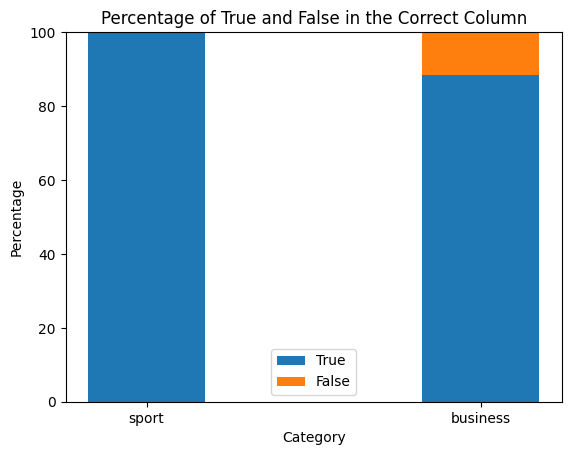

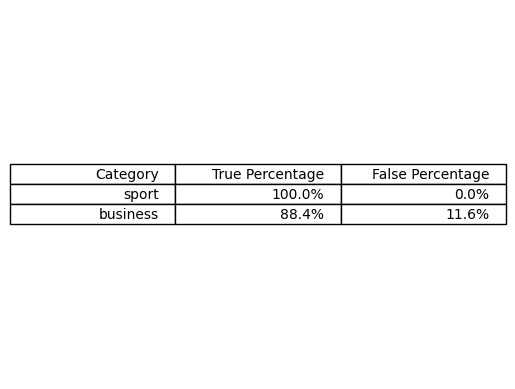

In [66]:
# We calculate the percentage of true and false values for each category
category_counts = bbc['category'].value_counts()
true_counts = bbc[bbc['correct'] == True]['category'].value_counts()
false_counts = category_counts - true_counts

# We calculate the percentage of true and false values
true_percentages = (true_counts / category_counts) * 100
false_percentages = (false_counts / category_counts) * 100

# We create a bar chart
fig, ax = plt.subplots()
x = range(len(category_counts))
bar_width = 0.35
ax.bar(x, true_percentages, width=bar_width, label='True')
ax.bar(x, false_percentages, width=bar_width, bottom=true_percentages, label='False')
ax.set_xticks(x)
ax.set_xticklabels(category_counts.index)
ax.set_xlabel('Category')
ax.set_ylabel('Percentage')
ax.set_title('Percentage of True and False in the Correct Column')
ax.legend()
plt.show()

# And a table to visualize it better
table_data = [['Category', 'True Percentage', 'False Percentage']]
for i, category in enumerate(category_counts.index):
    table_data.append([category, f'{true_percentages[i]:.1f}%', f'{false_percentages[i]:.1f}%'])
table = plt.table(cellText=table_data, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.2)
plt.axis('off')
plt.show()




As we can see, sport keeps rocking; although business does not. Therefore, our dataset may be more extrapolable than initially expected. We must remember the number of samples for each cayegory is nearly the same (510).

<div class="alert alert-block alert-danger">
  <b>Fourth conclusion:</b> Our dataset is more inferable than expected. Doing a multiclass resistance check, we see sports performance keeps doing well (100% recall, precision and accuracy), and business has an 88% of precision. The words analyzed before may be good for extrapolating! Knowing this was done with a BBC news dataset, we can affirm that the meme in our case has not been proven (at least for now). <b>And remember: this has been done with 30% of the original train dataset!</b>
</div>

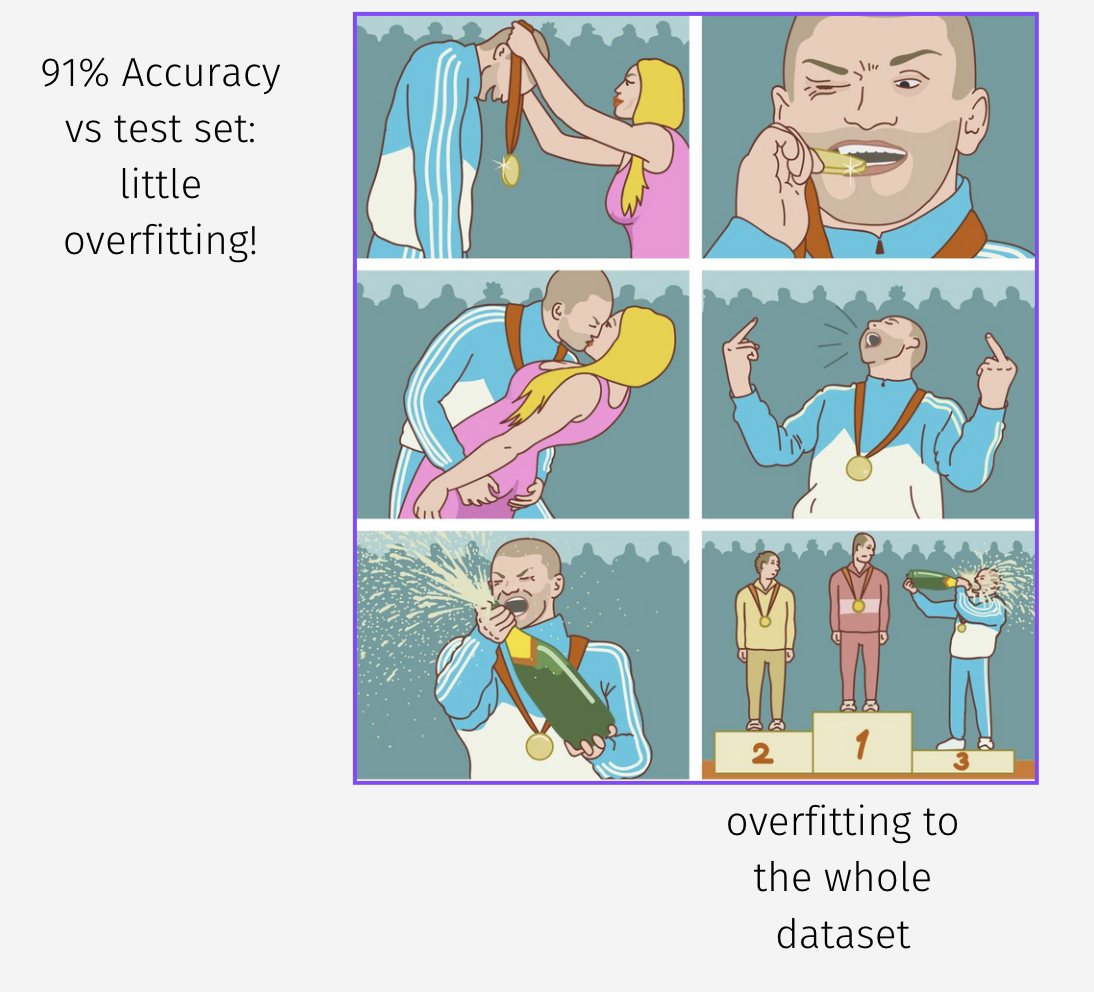

## Trying using Lemmatization from Spacy as a bag-of-lemmas

Lemmas reduce words to their dictionary forms. Let's see if by using those inflections, we are able to obtain better general results.

In [67]:
#We load spacy as we require
spacy_nlp=spacy.load("en_core_web_md")

In [68]:
#We lemmatize all rows in both train and test sets
def spacy_lemmatizer(text):
    doc = spacy_nlp(text)
    lemmas = [token.lemma_ for token in doc]
    return ' '.join(lemmas)  # Join the lemmas into a single string

# We preprocess the train and test data with the custom tokenizer
X_train_lemmas = [spacy_lemmatizer(text) for text in tqdm(train.text)]
X_test_lemmas = [spacy_lemmatizer(text) for text in tqdm(test.text)]


100%|████████████████████████████████████| 10000/10000 [01:24<00:00, 118.86it/s]


In [69]:
# Define the base sklearn pipeline with SGDClassifier and lemmas as bag-of-words
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)),
])

sgd_grid_parameters = {
    'vect__ngram_range': [(1, 1), (1, 2), (1, 3)],
    'clf__alpha': (1e-3, 1e-6, 1e-9, 1e-12)
}

grid_search = GridSearchCV(pipeline, sgd_grid_parameters, verbose=1, n_jobs=-1)
grid_search.fit(X_train_lemmas, train.label_int)
print("Best Parameters:")
print(grid_search.best_params_)
y_pred = grid_search.predict(X_test_lemmas)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters:
{'clf__alpha': 1e-06, 'vect__ngram_range': (1, 3)}


Best Parameters: {'clf__alpha': 1e-06, 'vect__ngram_range': (1, 3)}
              precision    recall  f1-score   support

     science       0.85      0.88      0.86      2537
      sports       0.92      0.97      0.95      2458
       world       0.91      0.88      0.89      2509
    business       0.88      0.83      0.86      2496

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



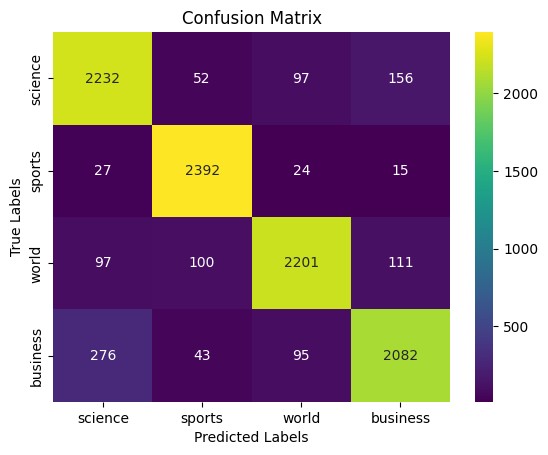

In [70]:
#We extract the best model with its correspondent hyperparameters first.
sgd_best=grid_search.best_estimator_
print('Best Parameters:', grid_search.best_params_)

results_multiclass(model_fit=sgd_best)

There is even worst metrics with same amount of data! Therefore, we can say that the model is better assisted when we provide words as they are rather than lemmatizing them like in a real-world dictionary style. Below you can see the picture of the 30% dataset with original words metrics and confusion matrix.

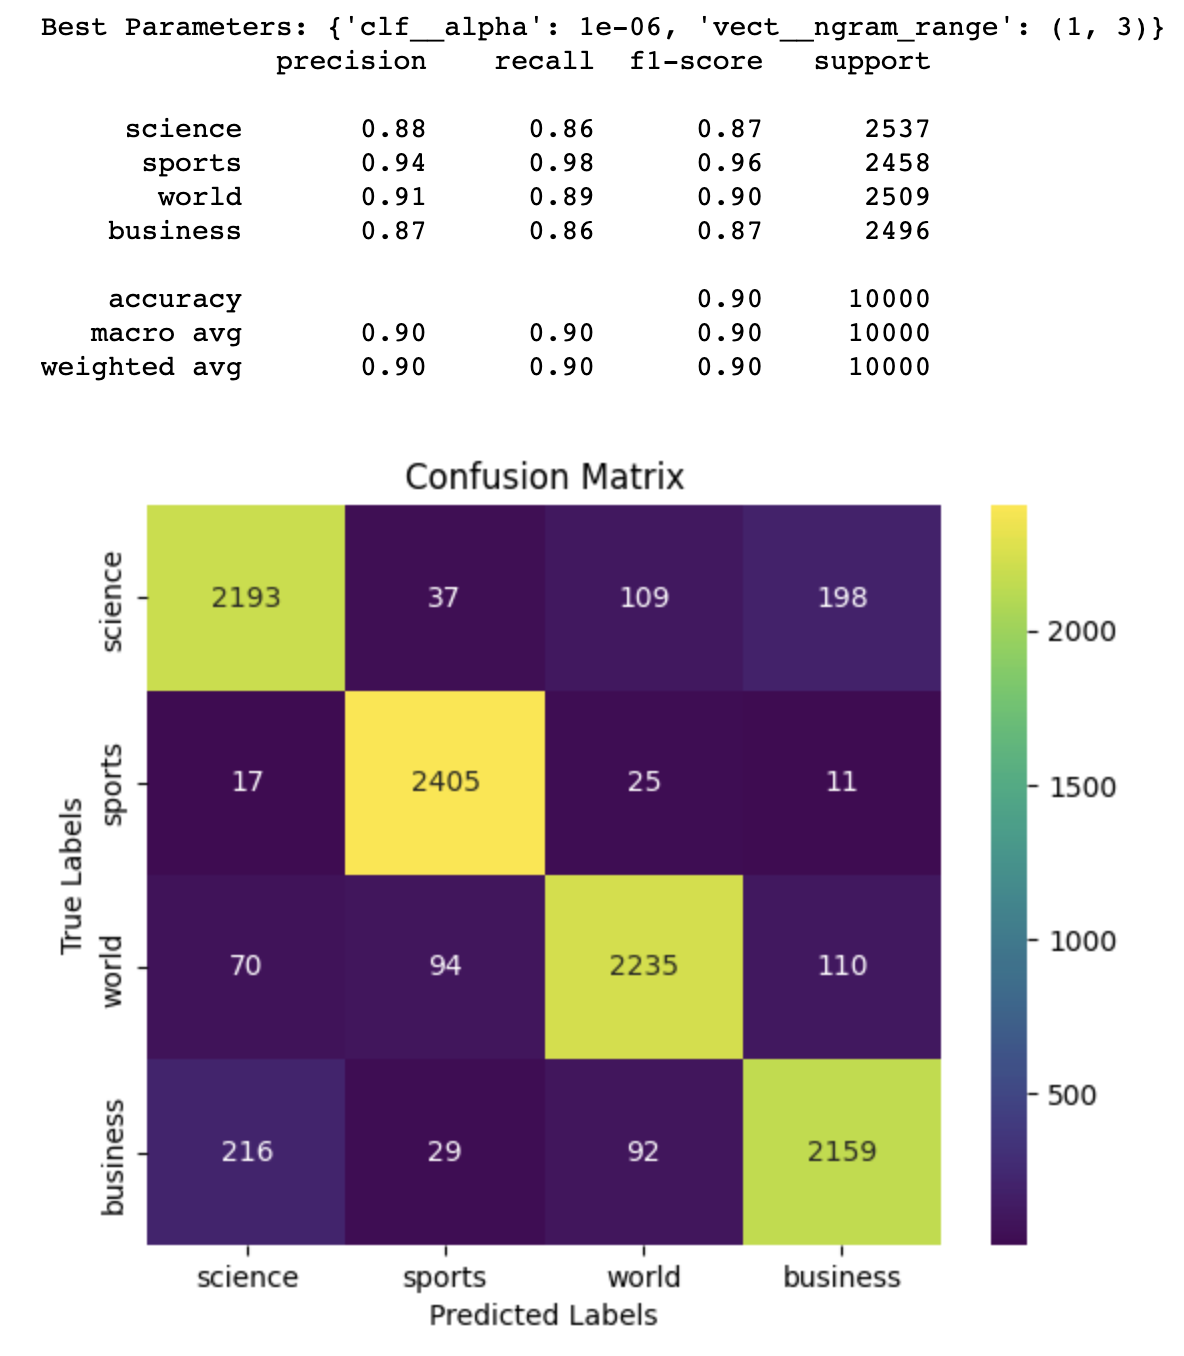

<div class="alert alert-block alert-danger">
  <b>Fifth conclusion:</b> Our model is able to better grasp the categories when using words-as-they-are, rather than with lemmatizations. This means that the literal use and position of words can give a little push upwards to prediction metrics!</b>
</div>